In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
np.random.seed(69)
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn import metrics
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from linformer import LinformerCA
from vit_pytorch.efficient_new import ViT  # updated file above

# ------------------------------------------------------------------
# Make sure model save dir exists
# ------------------------------------------------------------------
os.makedirs("Trained_Models", exist_ok=True)

# ------------------------------------------------------------------
# 1. Load and prepare data (same as your code)
# ------------------------------------------------------------------
X = np.load("/scratch/srinadb/Foundation/Dataset/Experiment1/X_exp1.npy")
dnnx = np.load("/scratch/srinadb/Foundation//Dataset/Experiment1/dnnx_exp1.npy")
objlist = np.load("/scratch/srinadb/Foundation//Dataset/Experiment1/objlist_exp1.npy")
y = np.load("/scratch/srinadb/Foundation//Dataset/Experiment1/y_exp1.npy", allow_pickle=True)

# Drop QSO
idx_drop = np.where(y == "QSO")[0]
X = np.delete(X, idx_drop, axis=0)
dnnx = np.delete(dnnx, idx_drop, axis=0)
y = np.delete(y, idx_drop, axis=0)
objlist = np.delete(objlist, idx_drop, axis=0)

# Factorize labels
y, label_strings = pd.factorize(y, sort=True)
print("\nLabels:", label_strings)

# Train / val / test split
zipX = list(zip(X, dnnx))
zipy = list(zip(y, objlist))

zipX_train, zipX_test, zipy_train, zipy_test = train_test_split(
    zipX, zipy, test_size=0.125, random_state=42
)
zipX_train, zipX_val, zipy_train, zipy_val = train_test_split(
    zipX_train, zipy_train, test_size=0.1428, random_state=42
)

X_train, dnnx_train = zip(*zipX_train)
X_val, dnnx_val = zip(*zipX_val)
X_test, dnnx_test = zip(*zipX_test)

y_train, objlist_train = zip(*zipy_train)
y_val, objlist_val = zip(*zipy_val)
y_test, objlist_test = zip(*zipy_test)

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

dnnx_train = np.array(dnnx_train)
dnnx_val = np.array(dnnx_val)
dnnx_test = np.array(dnnx_test)

y_train = np.array(y_train)
objlist_train = np.array(objlist_train)
y_val = np.array(y_val)
objlist_val = np.array(objlist_val)
y_test = np.array(y_test)
objlist_test = np.array(objlist_test)

del(zipX, zipX_test, zipX_train, zipX_val, X, zipy, zipy_test, zipy_train, zipy_val, objlist)

# Images to [N, C, H, W]
X_train = X_train.transpose((0, 3, 1, 2))
X_val = X_val.transpose((0, 3, 1, 2))
X_test = X_test.transpose((0, 3, 1, 2))

print('\n')
print('Train shape:', X_train.shape)
print('Val shape  :', X_val.shape)
print('Test shape :', X_test.shape)

# Feature dimension for pf (used to create dummy zeros in SimCLR)
PF_DIM = dnnx_train.shape[1]

# ------------------------------------------------------------------
# 2. Metrics helper
# ------------------------------------------------------------------
def get_metrics(y_pred, y_test, labels, to_print=True):
    correct_labels = np.where(y_pred == y_test)[0]
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred, average='macro')
    recall = metrics.recall_score(y_test, y_pred, average='macro')
    f1score = metrics.f1_score(y_test, y_pred, average='macro')
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
    classification_report = metrics.classification_report(y_test, y_pred)

    if to_print:
        print("Identified {} correct labels out of {} labels".format(len(correct_labels), y_test.shape[0]))
        print("Accuracy :", accuracy)
        print("Precision:", precision)
        print("Recall   :", recall)
        print("F1 Score :", f1score)
        print(f"Labels are: {labels}")
        print("Confusion Matrix:\n", confusion_matrix)
        print("Classification_Report:\n", classification_report)

    return (correct_labels, accuracy, precision, recall, confusion_matrix, classification_report)

# ------------------------------------------------------------------
# 3. Dataset classes
# ------------------------------------------------------------------
class SGContrastiveData(Dataset):
    """
    For SELF-SUPERVISED contrastive learning:
    returns (pf, img_view1, img_view2) but pf is IGNORED in SimCLR.
    """
    def __init__(self, x_pf, x_img, transform=None):
        self.x_pf = torch.tensor(x_pf, dtype=torch.float32)   # [N, PF_DIM]
        self.x_img = torch.tensor(x_img, dtype=torch.float32) # [N, C, H, W]
        self.transform = transform

    def __len__(self):
        return self.x_pf.shape[0]

    def __getitem__(self, idx):
        pf = self.x_pf[idx]   # kept for consistency, but not used in SSL
        img = self.x_img[idx] # [C, H, W]

        if self.transform:
            img_view1 = self.transform(img)
            img_view2 = self.transform(img)
        else:
            img_view1 = img
            img_view2 = img

        return pf, img_view1, img_view2


class SGData(Dataset):
    """
    For SUPERVISED classification: (pf, img, label).
    Fine-tuning will use BOTH pf + images here.
    """
    def __init__(self, x1, x2, y, transform=None):
        self.n_samples = x2.shape[0]
        self.x1 = torch.tensor(x1, dtype=torch.float32)
        self.x2 = torch.tensor(x2, dtype=torch.float32)
        self.y = torch.tensor(y)
        self.transform = transform

    def __len__(self):
        return self.n_samples

    def __getitem__(self, i):
        inputs_pf, inputs_imgs, targets = self.x1[i], self.x2[i], self.y[i]

        if self.transform:
            inputs_imgs = self.transform(inputs_imgs)

        return inputs_pf, inputs_imgs, targets

# ------------------------------------------------------------------
# 4. Data augmentation & loaders
# ------------------------------------------------------------------
image_transform = transforms.Compose([
    transforms.RandomRotation(180),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

# Contrastive datasets (SSL on images only; pf ignored later)
contrastive_train_dataset = SGContrastiveData(dnnx_train, X_train, transform=image_transform)
contrastive_val_dataset   = SGContrastiveData(dnnx_val,   X_val,   transform=image_transform)

contrastive_train_loader = DataLoader(contrastive_train_dataset, batch_size=1024, shuffle=True,  num_workers=8)
contrastive_val_loader   = DataLoader(contrastive_val_dataset,   batch_size=1024, shuffle=False, num_workers=4)

# Classification datasets (pf + image)
train_dataset = SGData(dnnx_train, X_train, y_train, transform=image_transform)
val_dataset   = SGData(dnnx_val,   X_val,   y_val,   transform=image_transform)
test_dataset  = SGData(dnnx_test,  X_test,  y_test,  transform=None)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True,  num_workers=8)
val_loader   = DataLoader(val_dataset,   batch_size=512, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset,  batch_size=512, shuffle=False, num_workers=4)

# ------------------------------------------------------------------
# 5. Model, contrastive wrapper & loss
# ------------------------------------------------------------------
n_classes = 2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

in_channels = X_train.shape[1]

PATCH_SIZE = 4
DEPTH      = 12
HIDDEN_DIM = 64
K_DIM      = 64
NUM_HEADS  = 8
LIN_DROPOUT = 0.1

LR_CONTRASTIVE    = 3e-3   # slightly higher LR for contrastive
LR_CLASSIFICATION = 1e-3
PROJ_DIM          = 128

seq_len = int((32 / PATCH_SIZE) ** 2) + 1  # num_patches + cls

# Linformer Cross-Attention
lin = LinformerCA(
    dim=HIDDEN_DIM,
    seq_len=seq_len,
    depth=DEPTH,
    k=K_DIM,
    heads=NUM_HEADS,
    dim_head=None,
    one_kv_head=False,
    share_kv=False,
    reversible=False,
    dropout=LIN_DROPOUT
)

# ViT backbone (shared)
backbone = ViT(
    image_size=32,
    patch_size=PATCH_SIZE,
    num_classes=n_classes,
    dim=HIDDEN_DIM,
    transformer=lin,
    pool='cls',
    channels=in_channels
).to(device)

class ContrastiveModel(nn.Module):
    """
    For SimCLR: use ONLY images.
    pf is replaced by zeros so SSL cannot cheat using pf features.
    """
    def __init__(self, backbone, proj_dim=128):
        super().__init__()
        self.backbone = backbone
        self.projector = nn.Sequential(
            nn.Linear(HIDDEN_DIM, proj_dim),
            nn.ReLU(inplace=True),
            nn.Linear(proj_dim, proj_dim)
        )

    def forward(self, img):
        # img: [B, C, H, W]
        B = img.size(0)
        pf_dummy = torch.zeros(B, PF_DIM, device=img.device)  # dummy pf
        h = self.backbone(pf_dummy, img, return_embedding=True)  # [B, HIDDEN_DIM]
        z = self.projector(h)                                   # [B, proj_dim]
        return h, z

contrastive_model = ContrastiveModel(backbone, proj_dim=PROJ_DIM).to(device)

# Standard SimCLR / NT-Xent loss (2 views)
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature

    def forward(self, z1, z2):
        # normalize
        z1 = F.normalize(z1, dim=1)
        z2 = F.normalize(z2, dim=1)
        B = z1.size(0)

        z = torch.cat([z1, z2], dim=0)  # [2B, D]
        sim = torch.matmul(z, z.T) / self.temperature  # [2B, 2B]

        # mask out self
        mask = torch.eye(2 * B, device=z.device, dtype=torch.bool)
        sim = sim.masked_fill(mask, -9e15)

        # positive for i: i+B (for first B) and i-B (for second B)
        pos_indices = torch.cat([
            torch.arange(B, 2 * B, device=z.device),
            torch.arange(0, B, device=z.device)
        ])
        pos_sim = sim[torch.arange(2 * B, device=z.device), pos_indices]

        # log-sum-exp over all others
        logsumexp = torch.logsumexp(sim, dim=1)

        loss = -pos_sim + logsumexp
        return loss.mean()

contrastive_loss_fn = NTXentLoss(temperature=0.1)

# ------------------------------------------------------------------
# 6. Self-supervised contrastive pretraining (IMAGE-ONLY SimCLR)
# ------------------------------------------------------------------
contrastive_optimizer = optim.Adam(contrastive_model.parameters(), lr=LR_CONTRASTIVE)

contrastive_epochs = 300
patience_contrastive = 20
best_contrastive_val_loss = float('inf')
best_contrastive_state = None
counter = 0

contrastive_train_loss_arr = []
contrastive_val_loss_arr = []

print("\n=== Self-supervised contrastive pretraining (IMAGE ONLY) ===")
for epoch in range(contrastive_epochs):
    # ---- TRAIN ----
    contrastive_model.train()
    total_train_loss = 0.0

    for batch_idx, (pf, img_v1, img_v2) in enumerate(contrastive_train_loader):
        # pf is ignored intentionally
        img_v1 = img_v1.to(device)
        img_v2 = img_v2.to(device)

        _, z1 = contrastive_model(img_v1)  # [B, D]
        _, z2 = contrastive_model(img_v2)  # [B, D]

        loss = contrastive_loss_fn(z1, z2)

        contrastive_optimizer.zero_grad()
        loss.backward()

        # Optional debug: gradient norm
        if batch_idx == 0:
            with torch.no_grad():
                gnorm = contrastive_model.projector[0].weight.grad.norm().item()
            print(f"[Epoch {epoch+1}] grad norm (projector[0].weight): {gnorm:.4e}")

        contrastive_optimizer.step()
        total_train_loss += loss.item()

    train_loss = total_train_loss / len(contrastive_train_loader)
    contrastive_train_loss_arr.append(train_loss)

    # ---- VALIDATION ----
    contrastive_model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for pf, img_v1, img_v2 in contrastive_val_loader:
            img_v1 = img_v1.to(device)
            img_v2 = img_v2.to(device)

            _, z1 = contrastive_model(img_v1)
            _, z2 = contrastive_model(img_v2)

            loss = contrastive_loss_fn(z1, z2)
            total_val_loss += loss.item()

    val_loss = total_val_loss / len(contrastive_val_loader)
    contrastive_val_loss_arr.append(val_loss)

    print(f"[Contrastive] Epoch [{epoch+1}/{contrastive_epochs}] - "
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping on contrastive val loss
    if val_loss < best_contrastive_val_loss:
        best_contrastive_val_loss = val_loss
        best_contrastive_state = contrastive_model.state_dict()
        counter = 0
        torch.save(best_contrastive_state, "Trained_Models/EX1_SG_MargFormer_Contrastive_Pretrain.pth")
    else:
        counter += 1

    if counter >= patience_contrastive:
        print(f"Early stopping contrastive pretraining at epoch {epoch+1}")
        break

# Load best contrastive weights
if best_contrastive_state is not None:
    contrastive_model.load_state_dict(best_contrastive_state)

# Plot contrastive loss curves
epochs_contrastive_range = range(1, len(contrastive_train_loss_arr) + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs_contrastive_range, contrastive_train_loss_arr, label='Train Loss')
plt.plot(epochs_contrastive_range, contrastive_val_loss_arr, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Contrastive Loss')
plt.title('Contrastive Pretraining Loss (Image-only SimCLR)')
plt.legend()
plt.savefig("Trained_Models/EX1_SG_MargFormer_Contrastive_Loss.png")
plt.close()

# ------------------------------------------------------------------
# 7. Supervised fine-tuning for classification (pf + images)
# ------------------------------------------------------------------
print("\n=== Supervised fine-tuning for classification (pf + images) ===")

model = contrastive_model.backbone  # reuse pretrained backbone

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR_CLASSIFICATION)

train_loss_arr = []
train_accuracy_arr = []
val_loss_arr = []
val_accuracy_arr = []

patience_cls = 30
best_val_loss = float('inf')
best_model_state = None
counter = 0
max_epochs_cls = 100

for epoch in range(max_epochs_cls):
    # ---- TRAIN ----
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_x1, batch_x2, batch_y in train_loader:
        batch_x1 = batch_x1.to(device)  # pf (USED here)
        batch_x2 = batch_x2.to(device)  # img
        batch_y  = batch_y.to(device)

        optimizer.zero_grad()
        output = model(batch_x1, batch_x2)  # logits using pf + img
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = output.max(1)
        total_train += batch_y.size(0)
        correct_train += predicted.eq(batch_y).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = correct_train / total_train
    train_loss_arr.append(train_loss)
    train_accuracy_arr.append(train_accuracy)

    # ---- VALIDATION ----
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for batch_x1, batch_x2, batch_y in val_loader:
            batch_x1 = batch_x1.to(device)
            batch_x2 = batch_x2.to(device)
            batch_y  = batch_y.to(device)

            output = model(batch_x1, batch_x2)
            loss = criterion(output, batch_y)
            val_loss += loss.item()

            _, predicted = output.max(1)
            total_val += batch_y.size(0)
            correct_val += predicted.eq(batch_y).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct_val / total_val
    val_loss_arr.append(val_loss)
    val_accuracy_arr.append(val_accuracy)

    print(f"[Classification] Epoch [{epoch+1}/{max_epochs_cls}] - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    # Early stopping on val loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        counter = 0
        torch.save(best_model_state, "Trained_Models/EX1_SG_MargFormer_Contrastive_Finetuned.pth")
    else:
        counter += 1

    if counter >= patience_cls:
        print(f"Early stopping classification at epoch {epoch+1}")
        if best_model_state is not None:
            model.load_state_dict(best_model_state)
        break

# ------------------------------------------------------------------
# 8. Plots for classification
# ------------------------------------------------------------------
epoch_range = range(1, len(train_loss_arr) + 1)

# Accuracy plot
plt.figure(figsize=(8, 6))
plt.plot(epoch_range, train_accuracy_arr, label='Train Accuracy')
plt.plot(epoch_range, val_accuracy_arr, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy (pf + image)')
plt.legend()
plt.savefig("Trained_Models/EX1_SG_MargFormer_Contrastive_Accuracy.png")
plt.close()

# Loss plot
plt.figure(figsize=(8, 6))
plt.plot(epoch_range, train_loss_arr, label='Train Loss')
plt.plot(epoch_range, val_loss_arr, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Classification Loss (pf + image)')
plt.legend()
plt.savefig("Trained_Models/EX1_SG_MargFormer_Contrastive_Loss_Class.png")
plt.close()

# ------------------------------------------------------------------
# 9. Final test evaluation
# ------------------------------------------------------------------
model.eval()
y_pred_list = []
y_true_list = []

with torch.no_grad():
    for batch_x1, batch_x2, batch_y in test_loader:
        batch_x1 = batch_x1.to(device)  # pf
        batch_x2 = batch_x2.to(device)  # img

        outputs = model(batch_x1, batch_x2)
        preds = outputs.argmax(dim=1).cpu().numpy()

        y_pred_list.append(preds)
        y_true_list.append(batch_y.numpy())

y_pred = np.concatenate(y_pred_list)
y_true = np.concatenate(y_true_list)

get_metrics(y_pred, y_true, label_strings, to_print=True)



Labels: ['GALAXY' 'STAR']


Train shape: (120007, 5, 32, 32)
Val shape  : (19992, 5, 32, 32)
Test shape : (20000, 5, 32, 32)
Device: cuda:0

=== Self-supervised contrastive pretraining (IMAGE ONLY) ===
[Epoch 1] grad norm (projector[0].weight): 5.3470e-02
[Contrastive] Epoch [1/300] - Train Loss: 5.0870, Val Loss: 3.0774
[Epoch 2] grad norm (projector[0].weight): 1.0070e+00
[Contrastive] Epoch [2/300] - Train Loss: 2.3927, Val Loss: 2.0131
[Epoch 3] grad norm (projector[0].weight): 1.2277e+00
[Contrastive] Epoch [3/300] - Train Loss: 1.8736, Val Loss: 1.5555
[Epoch 4] grad norm (projector[0].weight): 1.4187e+00
[Contrastive] Epoch [4/300] - Train Loss: 1.4380, Val Loss: 1.2892
[Epoch 5] grad norm (projector[0].weight): 1.0319e+00
[Contrastive] Epoch [5/300] - Train Loss: 1.2372, Val Loss: 1.1297
[Epoch 6] grad norm (projector[0].weight): 8.9122e-01
[Contrastive] Epoch [6/300] - Train Loss: 1.1202, Val Loss: 1.0535
[Epoch 7] grad norm (projector[0].weight): 8.0968e-01
[Contrastive] Epo

(array([    0,     1,     2, ..., 19997, 19998, 19999]),
 0.97725,
 0.9773018882691371,
 0.9772278042398266,
 array([[9679,  269],
        [ 186, 9866]]),
 '              precision    recall  f1-score   support\n\n           0       0.98      0.97      0.98      9948\n           1       0.97      0.98      0.98     10052\n\n    accuracy                           0.98     20000\n   macro avg       0.98      0.98      0.98     20000\nweighted avg       0.98      0.98      0.98     20000\n')

In [2]:
dnnx_sg = np.load("/scratch/srinadb/Foundation/Dataset/Experiment3/dnnx_sg_exp3.npy")
X_sg    = np.load("/scratch/srinadb/Foundation/Dataset/Experiment3/X_sg_exp3.npy")
X_sg    = X_sg.transpose((0, 3, 1, 2))   # -> [N, C, H, W]

y_sg = np.load("/scratch/srinadb/Foundation/Dataset/Experiment3/y_sg_exp3.npy")
y_sg = np.argmax(y_sg, axis=1)           # from one-hot to class indices

print(X_sg.shape)

# Same setup as training
n_classes = 2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

in_channels = X_sg.shape[1]   # should match X_train.shape[1]

PATCH_SIZE  = 4
DEPTH       = 12
HIDDEN_DIM  = 64
K_DIM       = 64
NUM_HEADS   = 8
LIN_DROPOUT = 0.1

seq_len = int((32 / PATCH_SIZE) ** 2) + 1  # num_patches + cls

# Recreate Linformer + ViT
lin_eval = LinformerCA(
    dim=HIDDEN_DIM,
    seq_len=seq_len,
    depth=DEPTH,
    k=K_DIM,
    heads=NUM_HEADS,
    dim_head=None,
    one_kv_head=False,
    share_kv=False,
    reversible=False,
    dropout=LIN_DROPOUT
)

model_eval = ViT(
    image_size=32,
    patch_size=PATCH_SIZE,
    num_classes=n_classes,
    dim=HIDDEN_DIM,
    transformer=lin_eval,
    pool='cls',
    channels=in_channels
).to(device)

# Load the fine-tuned weights
checkpoint_path = "Trained_Models/EX1_SG_MargFormer_Contrastive_Finetuned.pth"
state_dict = torch.load(checkpoint_path, map_location=device)
model_eval.load_state_dict(state_dict)
model_eval.eval()

# Reuse SGData from your script
class SGData(Dataset):
    def __init__(self, x1, x2, y, transform=None):
        self.n_samples = x2.shape[0]
        self.x1 = torch.tensor(x1, dtype=torch.float32)
        self.x2 = torch.tensor(x2, dtype=torch.float32)
        self.y  = torch.tensor(y,  dtype=torch.long)
        self.transform = transform

    def __len__(self):
        return self.n_samples

    def __getitem__(self, i):
        inputs_pf, inputs_imgs, targets = self.x1[i], self.x2[i], self.y[i]
        if self.transform:
            inputs_imgs = self.transform(inputs_imgs)
        return inputs_pf, inputs_imgs, targets

# Create dataset & loader for Experiment 3
sg_dataset = SGData(dnnx_sg, X_sg, y_sg, transform=None)
sg_loader  = DataLoader(sg_dataset, batch_size=512, shuffle=False, num_workers=4)

# Same get_metrics as in your script
def get_metrics(y_pred, y_test, labels, to_print=True):
    correct_labels = np.where(y_pred == y_test)[0]
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred, average='macro')
    recall = metrics.recall_score(y_test, y_pred, average='macro')
    f1score = metrics.f1_score(y_test, y_pred, average='macro')
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
    classification_report = metrics.classification_report(y_test, y_pred)

    if to_print:
        print("Identified {} correct labels out of {} labels".format(len(correct_labels), y_test.shape[0]))
        print("Accuracy :", accuracy)
        print("Precision:", precision)
        print("Recall   :", recall)
        print("F1 Score :", f1score)
        print(f"Labels are: {labels}")
        print("Confusion Matrix:\n", confusion_matrix)
        print("Classification_Report:\n", classification_report)

    return (correct_labels, accuracy, precision, recall, confusion_matrix, classification_report)

# Inference loop
model_eval.eval()
y_pred_list = []
y_true_list = []

with torch.no_grad():
    for batch_pf, batch_imgs, batch_y in sg_loader:
        batch_pf   = batch_pf.to(device)
        batch_imgs = batch_imgs.to(device)

        outputs = model_eval(batch_pf, batch_imgs)   # logits [B,2]
        preds = outputs.argmax(dim=1).cpu().numpy()

        y_pred_list.append(preds)
        y_true_list.append(batch_y.numpy())

y_pred_sg = np.concatenate(y_pred_list)
y_true_sg = np.concatenate(y_true_list)

print("\n=== Experiment 3 (Star/Galaxy) metrics ===")
get_metrics(y_pred_sg, y_true_sg, label_strings, to_print=True)




(19022, 5, 32, 32)

=== Experiment 3 (Star/Galaxy) metrics ===
Identified 17340 correct labels out of 19022 labels
Accuracy : 0.9115760698138997
Precision: 0.9204796526098169
Recall   : 0.9115760698138997
F1 Score : 0.9111054883961933
Labels are: ['GALAXY' 'STAR']
Confusion Matrix:
 [[9362  149]
 [1533 7978]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.86      0.98      0.92      9511
           1       0.98      0.84      0.90      9511

    accuracy                           0.91     19022
   macro avg       0.92      0.91      0.91     19022
weighted avg       0.92      0.91      0.91     19022



(array([    0,     1,     2, ..., 19019, 19020, 19021]),
 0.9115760698138997,
 0.9204796526098169,
 0.9115760698138997,
 array([[9362,  149],
        [1533, 7978]]),
 '              precision    recall  f1-score   support\n\n           0       0.86      0.98      0.92      9511\n           1       0.98      0.84      0.90      9511\n\n    accuracy                           0.91     19022\n   macro avg       0.92      0.91      0.91     19022\nweighted avg       0.92      0.91      0.91     19022\n')

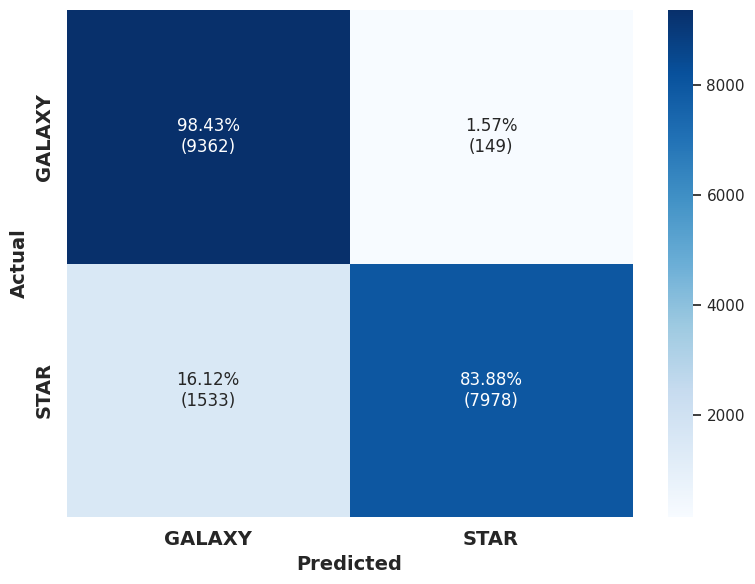

In [5]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Confusion matrix using your prediction variables
cf_matrix = metrics.confusion_matrix(y_true_sg, y_pred_sg)
cf_matrix_percentage = metrics.confusion_matrix(
    y_true_sg, y_pred_sg, normalize='true'
)

# Flatten and create labels with percentage + count
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix_percentage.flatten()]
labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_percentages, group_counts)]
labels = np.asarray(labels).reshape(2, 2)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', ax=ax)

ax.set_xlabel('Predicted', fontsize=14, weight='bold')
ax.set_ylabel('Actual', fontsize=14, weight='bold')

# Adjust these tick labels to match your class order (0 -> GALAXY, 1 -> STAR)
ax.xaxis.set_ticklabels(['GALAXY', 'STAR'], fontsize=14, weight='bold')
ax.yaxis.set_ticklabels(['GALAXY', 'STAR'], fontsize=14, weight='bold')

plt.tight_layout()
plt.savefig("Trained_Models/EX3_SG_MargFormerSCLR_CM.png")
plt.show()
# plt.close()
